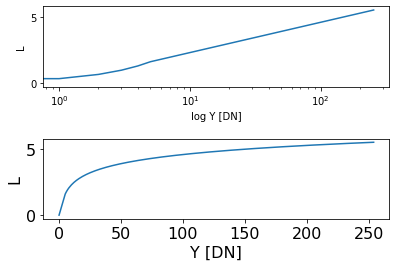

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from v2e.emulator import lin_log

y=np.array(range(255), float)
l=lin_log(y,threshold=5)

fnt=16
plt.subplot(211)
plt.rcParams.update({'font.size': fnt})
plt.plot(y,l)
plt.xlabel('log Y [DN]')
plt.ylabel('L')
plt.tight_layout()
plt.xscale('log')

plt.subplot(212)
plt.rcParams.update({'font.size': fnt})
plt.plot(y,l)
plt.xlabel('Y [DN]')
plt.ylabel('L')
plt.tight_layout()
plt.xscale('linear')

plt.savefig('../output/linlog.pdf')
plt.savefig('../media/linlog.png')




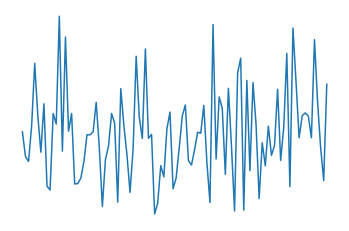

In [2]:
import numpy as np
from matplotlib import pyplot as plt

t=np.array(range(100),float)
n=np.random.randn(len(t))
fig=plt.figure(3)
plt.plot(t,n)
plt.axis('off')
plt.savefig('../output/noise.pdf')

In [3]:
# compute the expected number of temporal noise events per sample for a
# given sigma of gaussian noise sig and threshold th
import numpy as np
from math import erf, sqrt
# https://docs.python.org/3.2/library/math.html
def phi(x):
    'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

RnHzDesired=0.1 # desired rate of noise events per second
fsHz=100 # sample rate Hz
theta=.15 # event threshold in log_e units, but it doesn't matter what it is
# dumb search for best sigma
for sig in np.linspace(0,theta,1000):
    n=0
    for k in range(1,100):
        th0=k*theta
        th1=(k+1)*theta
        n+=k*(phi(th1/sig)-phi(th0/sig)) # weight expected # events times probability       
        Rn=fsHz*n
    if Rn>RnHzDesired:
        print('sig={:6.2f}\tn={:8.3g}ev/samp\tRn={:8.3g}ev/s'.format(sig,n,Rn))
        print('desired rate: {}'.format(RnHzDesired))
        break
 

C:\Users\Tobi\Anaconda3\envs\pt-v2e\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


sig=  0.05	n= 0.00102ev/samp	Rn=   0.102ev/s
desired rate: 0.1


In [4]:
import numpy as np
cutoffhz=10.
tau=1/(2*np.pi*cutoffhz)
fs=300.
dt=1/fs
eps=dt/tau



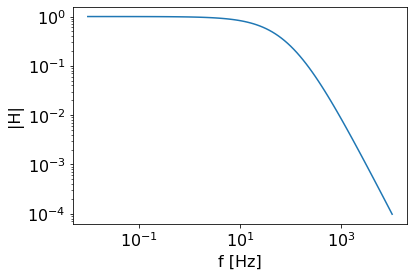

In [5]:
import numpy as np
f3dbhz=100.
f=np.logspace(-2,4,100)
s=2*np.pi*f
tau=1/(2*np.pi*f3dbhz)
a=tau*s+1
b=a*a
h=np.reciprocal(b)

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

fig=plt.figure(5)
plt.plot(f,h)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('|H|')
plt.savefig('../output/lowpass.pdf')

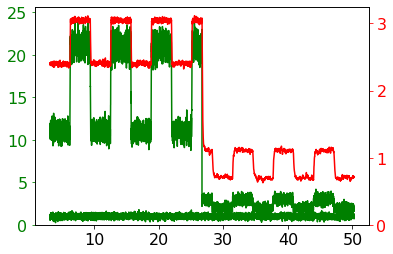

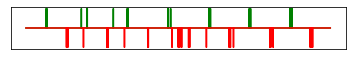

In [7]:
import numpy as np
from scipy.signal import square

dark=1 # dark current level
sigdc1=10 # DC photocurrent for bright half
sigdc2=1 # and dark half
cont=1 # contrast in each half
tau=.01 # time constant of lowpass
nper=4 # how many periods to simulate for each half bright/dark
thr=.1 # dvs threshold

dt=np.pi/500 # timesteps per half period
eps=dt/tau
if eps>1: 
    print('eps={:.3g} for tau={}, increase the number of time steps per cycle'.format(eps,tau))
    eps=1
t=np.arange(np.pi,nper*2*2*np.pi,dt)
npts=len(t)
npts2=int(npts/2)
sq=(square(t)+1)/2
sq=np.convolve(sq,np.ones(10)/10,mode='same')


sig=np.zeros_like(sq)
sig[:npts2]=sigdc1*(1+cont*sq[:npts2])
sig[npts2:]=sigdc2*(1+cont*sq[npts2:])

noiseFactor=.2
noise=noiseFactor*np.random.randn(t.shape[0])*np.sqrt(sig)
sig=sig+noise
darknoise=dark+noiseFactor*np.random.randn(t.shape[0])*np.sqrt(dark)

cur=sig+darknoise
logcur=np.log(cur) # log photoreceptor on sum of signal + dark current
ph1=np.zeros_like(logcur)
sf=np.zeros_like(logcur)
ph1[0]=logcur[0]
sf[0]=logcur[0]
for i in range(0,len(t)-1):
    tauactual=tau*max(cur)/cur[i] # nonlinear lowpass with time const tau for largest current
    e=dt/tauactual
    ph1[i+1]=(1-e)*ph1[i]+e*logcur[i] # only photorecptor tau changes
    sf[i+1]=(1-eps)*sf[i]+eps*ph1[i] # src follower tau is constant

# include DVS events
lmem=sf[0]
ons=np.zeros_like(t)
offs=np.zeros_like(t)
for i in range(1,len(t)):
    if sf[i]-lmem>=thr:
        ons[i]=1
        lmem=sf[i]
    elif sf[i]-lmem<=-thr:
        offs[i]=-1
        lmem=sf[i]
        
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

fig,ax1=plt.subplots(sharex=True)
ax1.plot(t,cur,'g',t,darknoise,'g')
ax1.set_ylim([0,None])
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')

ax2=ax1.twinx()
ax2.plot(t,sf,'r-')

ax2.set_ylim([0,None])
ax2.set_yscale('linear')
ax2.set_xscale('linear')
ax2.tick_params(axis='y', colors='red')

fig,ax3=plt.subplots(sharex=True)
offset=8
ax3.plot(t,offset+ons,'g', t,offset+offs,'r')
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.set_aspect(3)


# plt.xlabel('t [s]')
# plt.ylabel('[log]')
# plt.grid('on')


plt.savefig('../output/photo_dark_lowpass_curves.pdf')

In [8]:
f=2.8 # focal length
T=0.9 # lens transmittance
R=.18 # avg scene reflectance
lchip=np.logspace(0,4,5,endpoint=True)
factor=(4*f**2/T/R)
lscene=factor*lchip
print(lchip)
print(lscene)

[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[1.93580247e+02 1.93580247e+03 1.93580247e+04 1.93580247e+05
 1.93580247e+06]


total power=5245.084914114489


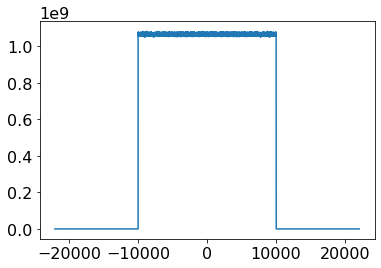

In [9]:
import numpy as np

def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return (np.fft.ifft(f).real)

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

from scipy.io import wavfile

x = band_limited_noise(0, 10000, 44100, 44100)
x = np.int16(x * (2**15 - 1))
wavfile.write("test.wav", 44100, x)

mean=np.mean(x)
power=(np.mean(x*x)-mean*mean)
print('total power={}'.format(power))
from matplotlib import pyplot as plt
plt.plot(x)

plt.cla()
freqs=np.fft.fftfreq(44100,1./44100)
ps = np.abs(np.fft.fft(x))**2
idx = np.argsort(freqs)
plt.plot(freqs[idx],ps[idx])

C:\Users\Tobi\Anaconda3\envs\pt-v2e\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
C:\Users\Tobi\Anaconda3\envs\pt-v2e\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


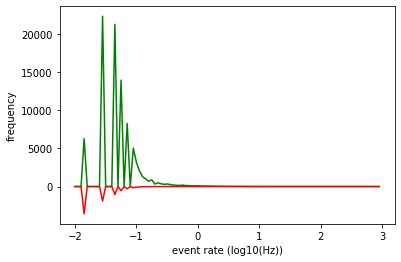

In [1]:
from v2e.v2e_utils import _inputFileDialog as ifd
fname=ifd([("AEDAT txt files", ".txt"),('Any type','*')])
from v2e.v2e_utils import read_aedat_txt_events
ev=read_aedat_txt_events(fname)




import numpy as np
sx=346
sy=260
npix=sx*sy
ntot=ev.shape[0]
non=np.count_nonzero(ev[:,3]==1)
noff=np.count_nonzero(ev[:,3]==0)
ttot=max(ev[:,0])-min(ev[:,0])
onrate=non/npix/ttot
offrate=noff/npix/ttot
onidx= np.where(ev[:,3]==1)
offidx=np.where(ev[:,3]==0)
# for each pixel, compute the spike rate
onev= ev[onidx, :][0]
offev=ev[offidx,:][0]

onx=onev[:,1]
ony=onev[:,2]
offx=offev[:,1]
offy=offev[:,2]



histrange = [(0, v) for v in (sx, sy)]
onhist,_,_= np.histogram2d(onx, ony, bins=(sx, sy), range=histrange)
offhist,_,_= np.histogram2d(offx, offy, bins=(sx, sy), range=histrange)


onhist=onhist.flatten()
offhist=offhist.flatten()
maxonhist=max(onhist)
maxoffhist=max(offhist)



onrates=np.flip(np.sort(onhist/ttot))
offrates=np.flip(np.sort(offhist/ttot))


logonrates=np.log10(onrates)
logoffrates=np.log10(offrates)



raterange=(-2,3)
nbins=100
onratehist,onbins=np.histogram(logonrates,bins=nbins, range=raterange)
offratehist,offbins=np.histogram(logoffrates,bins=nbins, range=raterange)
onratehist=onratehist
offratehist=offratehist


from matplotlib import pyplot as plt
plt.plot(onbins[:-1],(onratehist),'g',offbins[:-1],-(offratehist),'r')
plt.xlabel('event rate (log10(Hz))')
plt.ylabel('frequency')
figfname=fname.replace('.txt','.pdf')
plt.savefig(figfname)


In [1]:
import numpy as np
from engineering_notation import EngNumber as eng

dt=1e-4 # 
fs=1/dt
t=np.arange(0,3,dt)
npts=len(t)
    

def blnoise(f3db,t):
    dc=1 # and dark half
    tau=1/(2*np.pi*f3db) # time constant of lowpass
    eps=dt/tau
    if eps>1: 
        print('eps={:.3g} for tau={}, decrease timestep dt'.format(eps,tau))
        eps=1
    
    sig=dc*np.ones_like(t)

    noiseFactor=.1
    noise=noiseFactor*np.random.randn(t.shape[0])*np.sqrt(dc)
    sig=sig+noise
    
    logcur=np.log(sig) # log photoreceptor on sum of signal + dark current
    ph1=np.zeros_like(logcur)
    # sf=np.zeros_like(logcur)
    ph1[0]=np.log(dc)
    # sf[0]=ph1[0]
    for i in range(0,len(t)-1):
        e=eps
        ph1[i+1]=(1-e)*ph1[i]+e*logcur[i] # only photorecptor tau changes
        # sf[i+1]=(1-eps)*sf[i]+eps*ph1[i] # src follower tau is constant
        # print('x={:.2f} y1={:.2f} y2={:.2f}'.format(logcur[i],ph1[i+1],sf[i+1]))
    
    mean=np.mean(ph1)
    power=(np.mean(ph1*ph1)-mean*mean)
    ph1/=np.sqrt(power)
    mean=np.mean(ph1)
    power=(np.mean(ph1*ph1)-mean*mean)
    print('total power={}'.format(eng(power)))
    return ph1

ph1=blnoise(10,t)
ph2=blnoise(100,t)
ph3=blnoise(1000,t)

total power=1
total power=1
total power=1


In [8]:
def genev(ph,t):
    thr=1
    refr=5*dt
    tev=-refr # last event time
    # # include DVS events
    lmem=ph[0]
    ons=np.zeros_like(t)
    offs=np.zeros_like(t)
    for i in range(1,len(t)):
        if ph[i]-lmem>=thr:
            ons[i]=1
            lmem=ph[i]
        elif ph[i]-lmem<=-thr:
            offs[i]=-1
            lmem=ph[i]
    return ons,offs

ons1,offs1=genev(ph1,t)
ons2,offs2=genev(ph2,t)
ons3,offs3=genev(ph3,t)

freqs=np.fft.fftfreq(len(t),1./len(t))
idx = np.argsort(freqs)

def powerspec(sig):
    ps = np.abs(np.fft.fft(sig))**2
    return ps


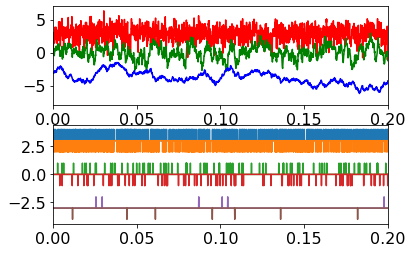

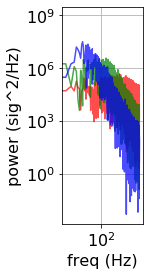

In [9]:
        
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams['pdf.fonttype'] = 42

plt.subplots(2,1,sharex=True)

plt.subplot(211)
# ax1.set_ylim([0,None])
# ax1.set_ylim((-3,3))
# ax1.tick_params(axis='y', colors='green')
# ax1.plot(t,ph3+3,'r',t,ph2,'g-',t,ph1-3,'b-')
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('signal')
plt.plot(t,ph3+3,'r',t,ph2,'g-',t,ph1-3,'b-')
plt.xlim((0,2000*dt))

plt.subplot(212)
plt.xlim((0,2000*dt))
plt.plot(t,ons3+3, t,offs3+3)
plt.plot(t,ons2, t,offs2)
plt.plot(t,ons1-3, t,offs1-3)

plt.savefig('noise-time.pdf')
plt.figure(2)


plt.loglog(freqs[idx],powerspec(ph3)[idx],'r-',alpha=.7)
plt.loglog(freqs[idx],powerspec(ph2)[idx],'g-',alpha=.7)
plt.loglog(freqs[idx],powerspec(ph1)[idx],'b-',alpha=.7)
plt.grid(True)
plt.xlabel('freq (Hz)')
plt.ylabel('power (sig^2/Hz)')
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('lognoise.pdf')


